## I'm having trouble with overfitting, and I have a suspicious it's due to redundant features. Here I see if automated feature selection outperforms manually removing highly correlated features

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
%matplotlib inline

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier

In [4]:
# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.model import load_and_process_training_data, feature_extraction, transformer_pipeline, full_pipeline
from lib.model import param_grid, f1_scorer, kfold
from lib.visualization import report_cv_scores

# from lib.pipeline import kfold, f1_scorer, FeatureExtractor, FeatureEngineer, LazyProcessing
# from lib.visualization import plot_confusion_matrix, plot_learning_curve
# from lib.preprocessing import preprocess
import lib.preprocessing as prep

In [5]:
X_train, y_train = load_and_process_training_data()

## No feature selection

In [6]:
cv_score = cross_val_score(full_pipeline, X_train, y_train, cv=kfold, scoring=f1_scorer, n_jobs=-1)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

Cross Validation F1 Score = 0.3517 with std = 0.0193


## Feature selection at a few thresholds

In [7]:
test_pipeline = Pipeline(steps=[
                        ('features', feature_extraction),
                        ('imputer', Imputer(strategy='mean')),
                        ('feature_scaler', StandardScaler()),
                        ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('random_forest', RandomForestClassifier(random_state=1))])


In [8]:
param_grid = dict(
                    feature_selection__threshold=[0.001, 0.005, 0.01,],
                    random_forest__max_depth=[20, 30])

In [9]:
%%time

grid = GridSearchCV(test_pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=1)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

{'feature_selection__threshold': 0.01, 'random_forest__max_depth': 20}
Wall time: 40.6 s


In [10]:
report_cv_scores(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.368 (std: 0.032)
Parameters: {'feature_selection__threshold': 0.01, 'random_forest__max_depth': 20}

Model with rank: 2
Mean validation score: 0.368 (std: 0.015)
Parameters: {'feature_selection__threshold': 0.01, 'random_forest__max_depth': 30}

Model with rank: 3
Mean validation score: 0.358 (std: 0.022)
Parameters: {'feature_selection__threshold': 0.001, 'random_forest__max_depth': 30}



## So, that's pretty underwhelming, with <0.1 improvement
## Let's try `RFECV`

In [11]:
X_transformed = transformer_pipeline.fit_transform(X_train)
rf = RandomForestClassifier(random_state=1, max_depth=30)

In [12]:
feature_selector = RFECV(rf, step = 0.02, cv = kfold, scoring=f1_scorer, n_jobs = -1)

In [13]:
%%time 

feature_selector.fit(X_transformed, y_train)
feature_selector.n_features_

Wall time: 11 s


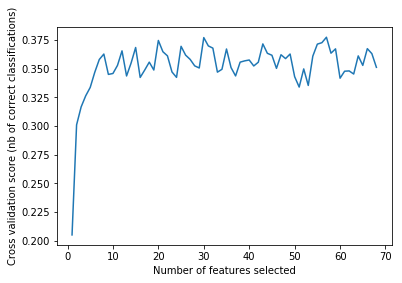

In [14]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(feature_selector.grid_scores_) + 1), feature_selector.grid_scores_)
plt.show()

## Still not amazing
## Now let's manually examine correlation
I have implemented within the feature engineering an option to `drop_correlated_features`, which will drop features with >=90% correlation with other features (preserving one of each set of correlated variables). Here I first demonstrate the functionality, then assess whether it helps the model

In [15]:
from lib.preprocessing import name_correlated_feature_to_drop
def plot_feature_correlation(data, feature_function, level, threshold=0.90, drop_correlated_features=False):
    df = feature_function(data, level, drop_correlated_features)
    corr_matrix = df.corr()
    #fig, ax = plt.subplots(figsize=(14, 12))
    #sns.heatmap(corr_matrix,annot=True, fmt = ".2f", cmap = "coolwarm", center=0, ax=ax)
    
    features = name_correlated_feature_to_drop(corr_matrix)
    if len(features) > 0:
        pass
        print(f'features to drop due to correlation >= {threshold}: {name_correlated_feature_to_drop(corr_matrix)}')
    # return corr_matrix

In [16]:
for f in [prep.feature_engineer_house_rankings, prep.feature_engineer_assets, prep.feature_engineer_demographics,
         prep.feature_engineer_education, prep.feature_engineer_house_characteristics, prep.feature_engineer_rent]:
    print(f)
    plot_feature_correlation(X_train, f, 'low')

<function feature_engineer_house_rankings at 0x0000019015168BF8>
features to drop due to correlation >= 0.9: ['roof_quality', 'floor_quality', 'house_material_bad', 'house_material_good', 'material_rank_sum', 'cielorazo', 'pisocemento', 'pisomoscer', 'paredblolad', 'epared1', 'epared3', 'etecho1', 'etecho3', 'eviv1', 'eviv3']
<function feature_engineer_assets at 0x0000019015168C80>
features to drop due to correlation >= 0.9: ['sanitario1']
<function feature_engineer_demographics at 0x0000019015168AE8>
features to drop due to correlation >= 0.9: ['child_percent', 'r4t1_percent_in_total', 'hhsize', 'hogar_nin', 'age']
<function feature_engineer_education at 0x0000019015168A60>
features to drop due to correlation >= 0.9: ['escolari', 'educ_rank', 'rez_esc_sum', 'no_primary_education', 'higher_education']
<function feature_engineer_house_characteristics at 0x0000019015168B70>
features to drop due to correlation >= 0.9: ['calc_dependency', 'rooms', 'bedrooms_per_person_household']
<function

In [17]:
plot_feature_correlation(X_train, prep.feature_engineer_house_rankings, 'low', drop_correlated_features=False)

features to drop due to correlation >= 0.9: ['roof_quality', 'floor_quality', 'house_material_bad', 'house_material_good', 'material_rank_sum', 'cielorazo', 'pisocemento', 'pisomoscer', 'paredblolad', 'epared1', 'epared3', 'etecho1', 'etecho3', 'eviv1', 'eviv3']


In [18]:
plot_feature_correlation(X_train, prep.feature_engineer_house_rankings, 'low', drop_correlated_features=True)

In [19]:
CORR = [False]
param_grid_normal = dict(features__extract_educ__drop_correlated_features=CORR,
                 features__extract_rent__drop_correlated_features=CORR,
                 features__extract_demog__drop_correlated_features=CORR,
                 features__extract_houseq__drop_correlated_features=CORR,
                 features__extract_housec__drop_correlated_features=CORR,
                 features__extract_assets__drop_correlated_features=CORR,
                 )

In [20]:
grid = GridSearchCV(full_pipeline, param_grid=param_grid_normal, cv=kfold, scoring=f1_scorer, n_jobs=1)
grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

[0.35168894]
{'features__extract_assets__drop_correlated_features': False, 'features__extract_demog__drop_correlated_features': False, 'features__extract_educ__drop_correlated_features': False, 'features__extract_housec__drop_correlated_features': False, 'features__extract_houseq__drop_correlated_features': False, 'features__extract_rent__drop_correlated_features': False}


In [21]:
CORR = [True]
param_grid_nocorr = dict(features__extract_educ__drop_correlated_features=CORR,
                 features__extract_rent__drop_correlated_features=CORR,
                 features__extract_demog__drop_correlated_features=CORR,
                 features__extract_houseq__drop_correlated_features=CORR,
                 features__extract_housec__drop_correlated_features=CORR,
                 features__extract_assets__drop_correlated_features=CORR,
                 )

In [22]:
grid = GridSearchCV(full_pipeline, param_grid=param_grid_nocorr, cv=kfold, scoring=f1_scorer, n_jobs=1)
grid.fit(X_train, y_train)

print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

[0.36755593]
{'features__extract_assets__drop_correlated_features': True, 'features__extract_demog__drop_correlated_features': True, 'features__extract_educ__drop_correlated_features': True, 'features__extract_housec__drop_correlated_features': True, 'features__extract_houseq__drop_correlated_features': True, 'features__extract_rent__drop_correlated_features': True}


## Well, nothing revolutionary, but it does seem that removing highly correlated features is marginally useful

In [23]:
gbm_params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}

test_pipeline = Pipeline(steps=[
                        ('features', feature_extraction),
                        ('imputer', Imputer(strategy='mean')),
                        ('feature_scaler', StandardScaler()),
                        ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('gbm', LGBMClassifier(**gbm_params, objective = 'multiclass',
                                                       n_jobs = -1, n_estimators = 1000,
                                                       random_state=1))])


In [24]:
%%time

cv_score = cross_val_score(test_pipeline, X_train, y_train, cv=kfold, scoring=f1_scorer, n_jobs=-1)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

Cross Validation F1 Score = 0.3886 with std = 0.0385
Wall time: 2min 28s


## randomized search for LGB hyperparameter tuning

In [43]:
from sklearn.model_selection import StratifiedKFold

In [51]:
%%time

# param_dist = dict(gbm__boosting_type=['dart'], 
#                   gbm__colsample_bytree=uniform(0.5,0.9), 
#                   gbm__learning_rate=uniform(0,0.1),
#                    gbm__min_child_samples=randint(5,20), 
#                    gbm__num_leaves=randint(5,50),
#                    gbm__reg_alpha=uniform(0.5,0.9), 
#                    gbm__reg_lambda=uniform(0.25,0.75), 
#                    gbm__subsample_for_bin=[1000,10000,50000], 
#                    gbm__subsample=uniform(0.25,0.75), 
#                    gbm__class_weight=['balanced'],
#                  )
param_dist = dict(gbm__boosting_type=['dart'],
                  gbm__learning_rate=uniform(0.01, 0.05)
                 )

kfold_light = StratifiedKFold(n_splits=2, random_state=1)
random_search = RandomizedSearchCV(test_pipeline, param_dist, cv=kfold_light, scoring=f1_scorer, n_jobs=-1,
                                  n_iter=2)
random_search.fit(X_train, y_train)

report_cv_scores(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.286 (std: 0.013)
Parameters: {'gbm__boosting_type': 'dart', 'gbm__learning_rate': 0.049118407831602255}

Model with rank: 2
Mean validation score: 0.222 (std: 0.036)
Parameters: {'gbm__boosting_type': 'dart', 'gbm__learning_rate': 0.05288335911056055}

Wall time: 1min 52s


In [33]:
from scipy.stats import randint
from scipy.stats import uniform

In [34]:
randint(0,10)

In [35]:
uniform(0,10)